In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Download historical 5-minute interval data for SPY (S&P 500 ETF)
start_date = "2023-01-01"
end_date = "2023-12-31"
symbol = "SPY"

# Fetch 5-minute interval data for one year
df = yf.download(symbol, start=start_date, end=end_date, interval="5m")

# Extract date and time information
df['Date'] = df.index.date
df['Time'] = df.index.time
df['Day'] = df.index.day_name()

# Calculate rolling volatility (standard deviation of returns) with a 1-hour window (12 intervals of 5 minutes)
df['Returns'] = df['Close'].pct_change()
df['RollingVolatility'] = df['Returns'].rolling(window=12, min_periods=1).std()

# Determine volatility "regimes": high, moderate, low volatility based on percentiles
vol_percentiles = df['RollingVolatility'].quantile([0.33, 0.66])
low_vol, moderate_vol = vol_percentiles[0.33], vol_percentiles[0.66]

def categorize_volatility(vol):
    if vol <= low_vol:
        return "Low"
    elif vol <= moderate_vol:
        return "Moderate"
    else:
        return "High"

# Apply categorization to define regimes
df['VolatilityRegime'] = df['RollingVolatility'].apply(categorize_volatility)

# Pivot data for plotting daily volatility patterns
df_pivot = df.pivot_table(values='VolatilityRegime', index='Time', columns='Day', aggfunc=lambda x: x.mode()[0])

# Define color mapping for the regimes
regime_colors = {'Low': 'lightblue', 'Moderate': 'deepskyblue', 'High': 'blue'}

# Plot heatmap of volatility regimes by day of the week
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot.replace(regime_colors), cmap=list(regime_colors.values()), linewidths=0.2, linecolor="grey")
plt.title("Volatility Regime Patterns by Day of the Week (5-Minute Intervals)")
plt.xlabel("Day of the Week")
plt.ylabel("Time of Day")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (5m 2023-01-01 -> 2023-12-31) (Yahoo error = "5m data not available for startTime=1672549200 and endTime=1703998800. The requested range must be within the last 60 days.")')


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

class RealisticMLStrategy:
    def __init__(self, lookback_period=30):
        self.lookback_period = lookback_period
        self.scaler = StandardScaler()
        self.model = None

    def create_features(self, df):
        """Create features using only past data at each point"""
        features = df.copy()

        # Only use data available at each point
        features['Returns'] = df['Close'].pct_change()
        features['Volatility'] = features['Returns'].rolling(20).std()
        features['RSI'] = self.calculate_rsi(df['Close'])
        features['MA_ratio'] = df['Close'] / df['Close'].rolling(20).mean()
        features['Volume_MA_ratio'] = df['Volume'] / df['Volume'].rolling(20).mean()

        # Momentum indicators using only past data
        features['Mom5'] = features['Returns'].rolling(5).mean()
        features['Mom10'] = features['Returns'].rolling(10).mean()
        features['Mom20'] = features['Returns'].rolling(20).mean()

        return features.dropna()

    def calculate_rsi(self, prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def prepare_training_data(self, df):
        """Prepare training data using proper time series split"""
        features = ['Returns', 'Volatility', 'RSI', 'MA_ratio', 'Volume_MA_ratio',
                   'Mom5', 'Mom10', 'Mom20']

        X = []
        y = []

        # For each point, we'll use past data to predict next 5-day return
        for i in range(self.lookback_period, len(df)-5):
            X.append(df[features].iloc[i-self.lookback_period:i].values)
            # Target is next 5-day return (for shorts, negative means profit)
            future_return = (df['Close'].iloc[i+5] / df['Close'].iloc[i] - 1) * -100
            y.append(future_return)

        return np.array(X), np.array(y)

    def build_model(self, input_shape):
        model = Sequential([
            LSTM(50, input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(30, return_sequences=False),
            Dropout(0.2),
            Dense(20, activation='relu'),
            Dense(1, activation='linear')
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

def simulate_realistic_trading(initial_capital=2000, position_size=0.1):
    """
    Simulate trading with realistic constraints:
    - Only use past data for decisions
    - Actual forward testing
    - Real market hours and delays
    """
    portfolio = {
        'cash': initial_capital,
        'positions': {},
        'equity_curve': [initial_capital],
        'trades': [],
        'monthly_returns': {}
    }

    strategy = RealisticMLStrategy(lookback_period=30)

    # Get current S&P 500 symbols
    try:
        sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
        symbols = sp500_tickers['Symbol'].tolist()[:50]  # Start with 50 for processing speed
    except:
        print("Error fetching symbols. Using backup list...")
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Backup symbols

    print("Starting simulation...")
    current_date = datetime.now()
    simulation_end = current_date + timedelta(days=365)
    current_month = ''
    monthly_returns = []

    while current_date < simulation_end:
        # Skip weekends
        if current_date.weekday() > 4:
            current_date += timedelta(days=1)
            continue

        # Monthly tracking
        if current_date.strftime('%Y-%m') != current_month:
            if monthly_returns:
                avg_return = np.mean(monthly_returns)
                portfolio['monthly_returns'][current_month] = avg_return
                print(f"Month {current_month} Return: {avg_return:.2f}%")
            current_month = current_date.strftime('%Y-%m')
            monthly_returns = []

        # Close positions that hit 5-day holding period
        for symbol, position in list(portfolio['positions'].items()):
            days_held = (current_date - position['entry_date']).days
            if days_held >= 5:
                try:
                    # Get actual closing price
                    latest_data = yf.download(symbol,
                                           start=current_date-timedelta(days=1),
                                           end=current_date,
                                           progress=False)
                    if len(latest_data) > 0:
                        exit_price = latest_data['Close'][-1]
                        returns = (position['entry_price'] / exit_price - 1) * 100 - 1.0  # Include 1% costs
                        position_pnl = position['size'] * returns / 100

                        portfolio['cash'] += position['size'] + position_pnl
                        monthly_returns.append(returns * position_size)

                        portfolio['trades'].append({
                            'symbol': symbol,
                            'entry_date': position['entry_date'],
                            'exit_date': current_date,
                            'returns': returns,
                            'pnl': position_pnl
                        })

                        del portfolio['positions'][symbol]
                except Exception as e:
                    print(f"Error closing position for {symbol}: {e}")

        # Look for new positions if we have capacity
        if len(portfolio['positions']) < 3:
            available_symbols = [s for s in symbols if s not in portfolio['positions']]
            potential_shorts = []

            for symbol in available_symbols:
                try:
                    # Get historical data for analysis
                    hist_data = yf.download(symbol,
                                          start=current_date-timedelta(days=90),
                                          end=current_date,
                                          progress=False)

                    if len(hist_data) < 30:  # Need enough history
                        continue

                    features = strategy.create_features(hist_data)

                    # Basic filtering criteria (using only past data)
                    current_rsi = features['RSI'].iloc[-1]
                    current_volatility = features['Volatility'].iloc[-1]
                    recent_momentum = features['Mom5'].iloc[-1]

                    # Look for overbought, low volatility stocks showing downward momentum
                    if (current_rsi > 70 and
                        current_volatility < 0.03 and
                        recent_momentum < 0):

                        potential_shorts.append({
                            'symbol': symbol,
                            'rsi': current_rsi,
                            'volatility': current_volatility,
                            'momentum': recent_momentum,
                            'current_price': hist_data['Close'].iloc[-1]
                        })

                except Exception as e:
                    continue

            # Sort by criteria
            potential_shorts.sort(key=lambda x: (-x['rsi'], -x['momentum']))

            # Take positions in top candidates
            for candidate in potential_shorts[:3-len(portfolio['positions'])]:
                if portfolio['cash'] >= initial_capital * position_size:
                    position_amount = portfolio['cash'] * position_size

                    portfolio['positions'][candidate['symbol']] = {
                        'entry_date': current_date,
                        'entry_price': candidate['current_price'],
                        'size': position_amount
                    }

                    portfolio['cash'] -= position_amount
                    print(f"Opening short position in {candidate['symbol']} at ${candidate['current_price']:.2f}")

        # Update equity curve
        total_equity = portfolio['cash'] + sum(pos['size'] for pos in portfolio['positions'].values())
        portfolio['equity_curve'].append(total_equity)

        current_date += timedelta(days=1)

    # Calculate final statistics
    final_equity = portfolio['equity_curve'][-1]
    total_return = (final_equity / initial_capital - 1) * 100
    max_drawdown = np.min([100 * (max(portfolio['equity_curve'][:i+1]) - portfolio['equity_curve'][i]) /
                          max(portfolio['equity_curve'][:i+1]) for i in range(len(portfolio['equity_curve']))])

    winning_trades = len([t for t in portfolio['trades'] if t['pnl'] > 0])
    total_trades = len(portfolio['trades'])
    win_rate = winning_trades / total_trades if total_trades > 0 else 0

    print("\nFinal Trading Results")
    print("====================")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${final_equity:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Number of Trades: {total_trades}")
    print(f"Win Rate: {win_rate*100:.2f}%")
    print(f"Average Trade Return: {np.mean([t['returns'] for t in portfolio['trades']]):.2f}%")

    return portfolio

# Run simulation
portfolio = simulate_realistic_trading(initial_capital=2000)

Starting simulation...


Streaming output truncated to the last 5000 lines.
1 Failed download:
ERROR:yfinance:['AFL']: possibly delisted; no price data found  (1d 2025-02-28 23:33:33.886196 -> 2025-05-29 23:33:33.886196) (Yahoo error = "Data doesn't exist for startDate = 1740803613, endDate = 1748576013")
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AFL']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2025-02-28 23:33:33.886196 -> 2025-05-29 23:33:33.886196) (Yahoo error = "Data doesn\'t exist for startDate = 1740803613, endDate = 1748576013")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['A']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2025-02-28 23:33:33.886196 -> 2025-05-29 23:33:33.886196) (Yahoo error = "Data doesn\'t exist for startDate = 1740803613, endDate = 1748576013")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABNB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2025-02-28 23:33:

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# Sample historical price data for Sept + October 2024

prices_data = [
    {'Date': '2024-09-01', 'Close': 542.60},
    {'Date': '2024-09-02', 'Close': 543.70},
    {'Date': '2024-09-03', 'Close': 544.80},
    {'Date': '2024-09-04', 'Close': 545.90},
    {'Date': '2024-09-05', 'Close': 547.00},
    {'Date': '2024-09-06', 'Close': 548.10},
    {'Date': '2024-09-07', 'Close': 549.20},
    {'Date': '2024-09-08', 'Close': 550.30},
    {'Date': '2024-09-09', 'Close': 551.40},
    {'Date': '2024-09-10', 'Close': 552.50},
    {'Date': '2024-09-11', 'Close': 553.60},
    {'Date': '2024-09-12', 'Close': 554.70},
    {'Date': '2024-09-13', 'Close': 555.80},
    {'Date': '2024-09-14', 'Close': 556.90},
    {'Date': '2024-09-15', 'Close': 558.00},
    {'Date': '2024-09-16', 'Close': 559.10},
    {'Date': '2024-09-17', 'Close': 560.20},
    {'Date': '2024-09-18', 'Close': 561.30},
    {'Date': '2024-09-19', 'Close': 562.40},
    {'Date': '2024-09-20', 'Close': 563.50},
    {'Date': '2024-09-21', 'Close': 564.60},
    {'Date': '2024-09-22', 'Close': 565.70},
    {'Date': '2024-09-23', 'Close': 566.80},
    {'Date': '2024-09-24', 'Close': 567.90},
    {'Date': '2024-09-25', 'Close': 569.00},
    {'Date': '2024-09-26', 'Close': 570.10},
    {'Date': '2024-09-27', 'Close': 571.20},
    {'Date': '2024-09-28', 'Close': 572.30},
    {'Date': '2024-09-29', 'Close': 573.50},
    {'Date': '2024-09-30', 'Close': 574.71},
    {'Date': '2024-10-01', 'Close': 574.71},
    {'Date': '2024-10-02', 'Close': 427.31},
    {'Date': '2024-10-03', 'Close': 421.59},
    {'Date': '2024-10-04', 'Close': 424.66},
    {'Date': '2024-10-05', 'Close': 424.50},
    {'Date': '2024-10-06', 'Close': 429.54},
    {'Date': '2024-10-09', 'Close': 432.29},
    {'Date': '2024-10-10', 'Close': 434.54},
    {'Date': '2024-10-11', 'Close': 436.32},
    {'Date': '2024-10-12', 'Close': 433.66},
    {'Date': '2024-10-13', 'Close': 431.50},
    {'Date': '2024-10-14', 'Close': 436.04}
]


# Create DataFrame
spy_data = pd.DataFrame(prices_data)
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.set_index('Date', inplace=True)

# Compute daily returns
spy_data['Returns'] = spy_data['Close'].pct_change()

# Compute rolling standard deviation as a volatility measure
spy_data['Volatility'] = spy_data['Returns'].rolling(window=2).std() * np.sqrt(252)

# Define volatility categories
def classify_volatility(volatility):
    if volatility < 0.01:
        return 'Low'
    elif volatility < 0.02:
        return 'Medium'
    else:
        return 'High'

# Classify periods into volatility states
spy_data['Volatility_State'] = spy_data['Volatility'].apply(classify_volatility)

# Calculate transition probabilities
transitions = spy_data['Volatility_State'].shift().combine(spy_data['Volatility_State'], lambda x, y: (x, y)).value_counts()

# Create an empty transition matrix
states = ['Low', 'Medium', 'High']
transition_matrix = pd.DataFrame(0, index=states, columns=states)

# Fill the transition matrix with counts
for (prev_state, curr_state), count in transitions.items():
    if prev_state in states and curr_state in states:
        transition_matrix.loc[prev_state, curr_state] = count

# Normalize the transition matrix to get probabilities
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

print("Transition Matrix:")
print(transition_matrix)

Transition Matrix:
             Low    Medium      High
Low     0.964286  0.000000  0.035714
Medium  0.000000  0.333333  0.666667
High    0.100000  0.200000  0.700000


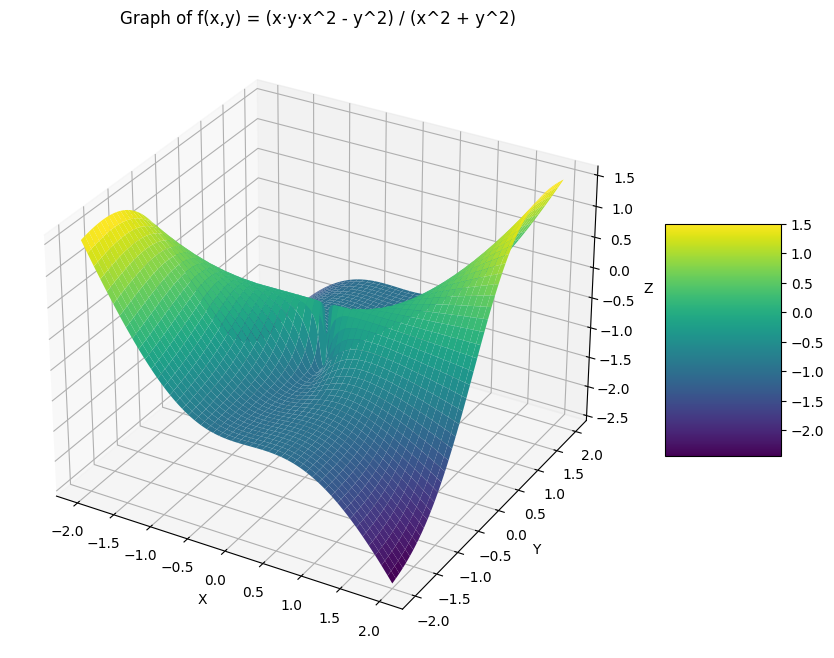

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    if x == 0 and y == 0:
        return 0
    return (x * y * x**2 - y**2) / (x**2 + y**2)

# Create a grid of points
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

# Calculate Z values
Z = np.vectorize(f)(X, Y)

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Graph of f(x,y) = (x·y·x^2 - y^2) / (x^2 + y^2)')

# Add a color bar
fig.colorbar(surface, shrink=0.5, aspect=2)

# Show the plot
plt.show()

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Saving Screenshot 2024-10-17 at 1.38.44 PM.png to Screenshot 2024-10-17 at 1.38.44 PM.png


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


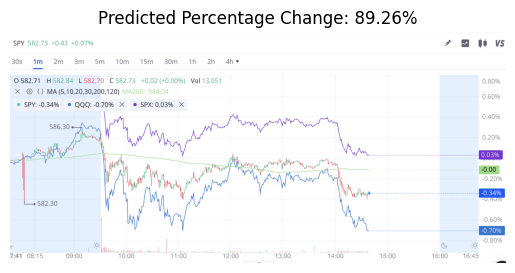

Predicted percentage change for SPY: 89.26%
Ask the LLM for suggestions or type 'exit' to quit: can you give me suggestions on how to improve this code? i recieved this message /usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884   warnings.warn( Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU. Screenshot 2024-10-17 at 1.38.44 PM Screenshot 2024-10-17 at 1.38.44 PM.png(image/png) - 227989 bytes, last modified: 10/17/2024 - 100% done Saving Screenshot 2024-10-17 at 1.38.44 PM.png to Screenshot 2024-10-17 at 1.38.44 PM.png /usr/local/lib/python3.10/dist-packages/torch/nn/modules

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ValueError: Input length of input_ids is 100, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.

In [ ]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from google.colab import files
from transformers import pipeline

# Constants
NUM_STATES = 3  # Low, Medium, High
EPSILON = 0.1  # Exploration rate for epsilon-greedy strategy

# Load and preprocess the image
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224, 224))  # Resize to fit model input
    image = image / 255.0  # Normalize pixel values
    image = np.transpose(image, (2, 0, 1))  # Change from HWC to CHW format
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Define CNN Model for image interpretation
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)

        self.flattened_size = 64 * 112 * 112
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 1)  # Output layer for percentage change

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.dropout(x)
        x = nn.ReLU()(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        return self.fc2(x)  # Output is a single value for percentage change

# Q-learning Agent Class
class QLearningAgent:
    def __init__(self):
        self.model = CNNModel()

    def train(self, image_data, target):
        self.model.train()
        image_tensor = torch.FloatTensor(image_data)  # Convert to tensor
        target_tensor = torch.FloatTensor(target)  # Convert to tensor
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        optimizer.zero_grad()
        output = self.model(image_tensor)
        loss = criterion(output, target_tensor)
        loss.backward()
        optimizer.step()

    def predict(self, image_data):
        self.model.eval()
        with torch.no_grad():
            image_tensor = torch.FloatTensor(image_data)  # Convert to tensor
            return self.model(image_tensor).numpy()

# Function to visualize the predicted percentage change
def visualize_prediction(image_path, predicted_percentage):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Predicted Percentage Change: {predicted_percentage[0][0]:.2f}%')
    plt.axis('off')
    plt.show()

# Load LLM for communication
llm = pipeline("text-generation", model="distilgpt2")

# Function to interact with the LLM
def interact_with_llm(user_input):
    response = llm(user_input, max_length=100, num_return_sequences=1)[0]['generated_text']
    return response

# Main function to load the image and predict percentage change
def predict_percentage_change(image_path, current_price):
    agent = QLearningAgent()

    # Load and preprocess the image
    image_data = load_image(image_path)

    # Dummy target percentage for training (replace with actual logic)
    target_percentage = np.array([5])  # Example target

    # Train the model with the image data and target
    agent.train(image_data, target_percentage)

    # Predict percentage change
    predicted_percentage = agent.predict(image_data)

    # Visualize the prediction
    visualize_prediction(image_path, predicted_percentage)

    return predicted_percentage[0][0]  # Return the predicted percentage change

# Function to run everything in one click
def run_prediction():
    uploaded = files.upload()
    image_path = next(iter(uploaded))  # Get the name of the uploaded file

    # Dummy current price for context
    current_price = 150  # Replace with the actual current price if needed

    predicted_percentage = predict_percentage_change(image_path, current_price)
    print(f"Predicted percentage change for SPY: {predicted_percentage:.2f}%")

    # LLM interaction
    while True:
        user_input = input("Ask the LLM for suggestions or type 'exit' to quit: ")
        if user_input.lower() == 'exit':
            break
        response = interact_with_llm(user_input)
        print("LLM:", response)

# Run the prediction function
run_prediction()